In [1]:
from os.path import dirname, join, pardir
from cobra.io import read_sbml_model
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from dfba.plot.matplotlib import *
from escher import Builder
import numpy as np
import math

In [2]:
data_dir = "/Users/phivri/Documents/GitHub/MoGeoModel"

In [3]:
model = read_sbml_model(join(data_dir,'Models/p-thermo_acetone_anaerobic.xml'))

medium = model.medium
medium["EX_o2_e"] = 1000.0
medium["EX_ac_e"] = 10.0
medium["EX_glc__D_e"] = 0.0
model.medium = medium

Using license file /Users/phivri/gurobi.lic
Academic license - for non-commercial use only - expires 2022-07-23


In [4]:
#Desired ratio of max growth, chosen from PPP:
ratio = 0.5

XFlux = model.slim_optimize()*ratio

with model:
    model.reactions.get_by_id("EX_Biomass_e").bounds = XFlux, XFlux
    model.objective = "EX_act_e"
    PFlux = model.slim_optimize()

set_flux = model.problem.Constraint(
    XFlux * model.reactions.EX_act_e.flux_expression - PFlux * model.reactions.EX_Biomass_e.flux_expression,
    lb=0,
    ub=0)
model.add_cons_vars(set_flux)

model.objective = "EX_act_e"

solution = model.optimize()
Builder(model = model, map_json = join(data_dir,'Models/AcetonePathway.json'), reaction_data = solution.fluxes.to_dict())

Builder(reaction_data={'IDPh': 8.237433427614356, 'CAT': -5.141076463187653e-09, 'PDHam1hi': 0.0, 'HYDA': 0.0,…

In [5]:
model.solver = "glpk"
dfba_model = DfbaModel(model)

In [6]:
X = KineticVariable("Biomass")#, initial_condition=C2_X_het_0)
Actt = KineticVariable("Acetate")#, initial_condition=C2_Actt_0)
Actn = KineticVariable("Acetone")#, initial_condition=C2_Actn_0)
O2 = KineticVariable("Oxygen")#, initial_condition=C2_O2_0)
CO2 = KineticVariable("CarbonDioxide")#, initial_condition=C2_CO2_0)

# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Actt, Actn, O2, CO2])

# instances of ExchangeFlux
µ_het = ExchangeFlux("EX_Biomass_e")
q_het_Actt = ExchangeFlux("EX_ac_e")
q_het_Actn = ExchangeFlux("EX_act_e")
q_het_O2 = ExchangeFlux("EX_o2_e")
q_het_CO2 = ExchangeFlux("EX_co2_e")

dfba_model.add_initial_conditions(
    {
        "Biomass": 1,
        "Acetate": 10,
        "Acetone": 0,
        "Oxygen": 10,
        "CarbonDioxide": 0,
    }
)

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([µ_het,q_het_Actt,q_het_Actn,q_het_O2,q_het_CO2])

# add rhs expressions for kinetic variables in dfba_model
dfba_model.add_rhs_expression("Biomass", µ_het * X)
dfba_model.add_rhs_expression("Acetate", q_het_Actt * X)# 60 * X / 1000.0)
dfba_model.add_rhs_expression("Acetone", q_het_Actn * X)# * 58 * X / 1000.0)
dfba_model.add_rhs_expression("Oxygen", q_het_O2 * X + 10)# * 32 * X / 1000.0 + 10)
dfba_model.add_rhs_expression("CarbonDioxide", q_het_O2 * X)# * 44 * X / 1000.0)

# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_ac_e", 10.5 * (Actt / (0.0027 + Actt)), Actt)
dfba_model.add_exchange_flux_lb("EX_o2_e", 15.0 * (O2 / (0.024 + O2)), O2)

# simulate model across interval t = [0.0,25.0](hours) with outputs for plotting
# every 0.1h and optional list of fluxes
concentrations, trajectories = dfba_model.simulate(
    0.0, 25.0, 0.1, ["EX_Biomass_e","EX_o2_e","EX_co2_e","EX_ac_e", "EX_act_e"]#, "EX_etoh(e)"]
)

In [7]:
dfba_model.reactions.biomass

Reaction identifier,biomass
Name,biomass
Memory address,0x07fb391cb64a8
Stoichiometry,0.000357142857142857 10fthf_c + 0.000249107142857144 accoa_c + 0.000199107142857143 adocbl_c + 0.514187446428571 ala__L_c + 0.000199107142857143 amet_c + 0.119274155357143 amp_c + 0.183080357142857... 0.000357142857142857 10-Formyltetrahydrofolate + 0.000249107142857144 Acetyl-CoA + 0.000199107142857143 Cobamide coenzyme + 0.514187446428571 L-Alanine + 0.000199107142857143 S-Adenosyl-L-...
GPR,RTMO05969
Lower bound,0.0
Upper bound,1000.0


In [8]:
concentrations

,time,Acetate,Acetone,Biomass,CarbonDioxide,Oxygen
0,0.0,10.000000,0.000000,1.000000,0.000000,10.000000
1,0.1,8.950567,-0.015318,0.999490,-0.080459,10.919541
2,0.2,7.901709,-0.030628,0.998980,-0.160878,11.839122
3,0.3,6.853448,-0.045931,0.998471,-0.241255,12.758745
4,0.4,5.805784,-0.061225,0.997961,-0.321592,13.678408
...,...,...,...,...,...,...
245,24.5,-0.002842,-3.527858,0.882537,-18.530394,236.469606
246,24.6,-0.002842,-3.541378,0.882087,-18.601406,237.398594
247,24.7,-0.002842,-3.554890,0.881637,-18.672382,238.327618
248,24.8,-0.002842,-3.568396,0.881187,-18.743319,239.256681


In [9]:
trajectories

,time,EX_Biomass_e,EX_o2_e,EX_co2_e,EX_ac_e,EX_act_e
0,0.0,0.000000,0.000000,0.000000,0.000000,0.00000
1,0.1,-0.005102,-0.804799,0.642874,-10.496834,-0.15322
2,0.2,-0.005102,-0.804799,0.642874,-10.496413,-0.15322
3,0.3,-0.005102,-0.804799,0.642874,-10.495865,-0.15322
4,0.4,-0.005102,-0.804799,0.642874,-10.495119,-0.15322
...,...,...,...,...,...,...
245,24.5,-0.005102,-0.804799,0.642874,0.000000,-0.15322
246,24.6,-0.005102,-0.804799,0.642874,0.000000,-0.15322
247,24.7,-0.005102,-0.804799,0.642874,0.000000,-0.15322
248,24.8,-0.005102,-0.804799,0.642874,0.000000,-0.15322


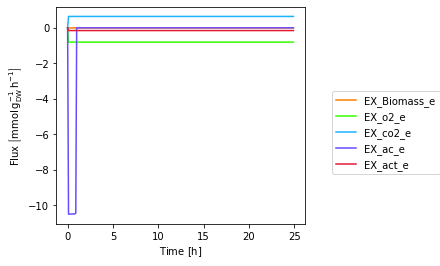

In [10]:
plot_trajectories(trajectories)

In [11]:
?plot_trajectories()

Object `plot_trajectories()` not found.
